## Multi-category Dance Classifier

In this notebook I explain the development of a deep learning model that identify the kind of dance based 
on an image. As a result the new model can identify one or more dance styles in the same picture.

I use around 450 images. It is possible to get good results with few images applying diferent techniques as 
Data Augmentation and Transfer Learning. For Data Augmentation i applied a technique call presizing from fastai, which apply these steps:

- Resize images to relatively "large" dimensions—that is, dimensions significantly larger than the target training dimensions.
- Compose all of the common augmentation operations (rotation, zoom, resize, etc) into one, and perform the combined operation on the GPU only once at the end of processing, rather than performing the operations individually and interpolating multiple times.

For Transfer Learning i used the model "resnet18" and "resnet50", both models were pre-trained on ImageNet (ImageNet contains over 1.3 million images of various sizes around 500 pixels across, in 1,000 categories, the model took a few days to train)

First of all I load the necessary libraries, in this case fast.ai which relies on pytorch.

In [1]:
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.vision.widgets import *
import secrets
torch.cuda.set_device('cuda:1')

## Gathering Data

I get the images using the Microsoft Azure Bing Search Api. 

In [2]:
key = os.environ.get('AZURE_SEARCH_KEY', secrets.AZURE_KEY)
dance_types = 'hiphop','lindyhop','salsa'
path = Path('dance')

if not path.exists():
    path.mkdir()
    for o in dance_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} dance', 128, 300)
        download_images(dest, urls=results.attrgot('contentUrl'))
        
fns = get_image_files(path)
fns


 Download of http://www.deasislanddance.com/wp-content/uploads/2011/02/Hip-Hop-Pic.jpg has failed after 5 retries
 Fix the download manually:
$ mkdir -p dance/hiphop
$ cd dance/hiphop
$ wget -c http://www.deasislanddance.com/wp-content/uploads/2011/02/Hip-Hop-Pic.jpg
$ tar xf Hip-Hop-Pic.jpg
 And re-run your code once the download is successful



(#432) [Path('dance/hiphop/00000000.jpg'),Path('dance/hiphop/00000001.jpg'),Path('dance/hiphop/00000002.jpg'),Path('dance/hiphop/00000003.jpg'),Path('dance/hiphop/00000004.jpg'),Path('dance/hiphop/00000005.jpg'),Path('dance/hiphop/00000006.jpg'),Path('dance/hiphop/00000007.jpg'),Path('dance/hiphop/00000008.jpg'),Path('dance/hiphop/00000009.jpg')...]

I got around 450 images. By default I try to get 150 images maximum for each category every time I query the Bing API through "search_images_bing" function. According to the messages some of them fail to download.

I use the "get_image_files" function to check the files we just download. Displaying variable "fns" show the total of files and the path for each of them.

The dataset will be made up of the images as the independent variable "x" and the categories they belong as the dependent variable "y".

In fastai we have a function to verify the images we downloaded are ok. 

In [3]:
failed = verify_images(fns)
failed

(#5) [Path('dance/hiphop/00000005.jpg'),Path('dance/hiphop/00000061.jpg'),Path('dance/hiphop/00000083.jpg'),Path('dance/salsa/00000003.jpeg'),Path('dance/salsa/00000085.jpg')]

Some files are empty or corrupt. To remove them, you can use unlink on each of them.

In [4]:
failed.map(Path.unlink);

The category of each image is defined by the name of the parent directory. I define the "parent_label_multi" function to get the category.

In [5]:
def parent_label_multi(o):
    return [Path(o).parent.name]

## Dataloaders

It's time to load our data. To do it fastai has a flexible system called the data block API. We need to specify:

- What kinds of data we are working with
- How to get the list of items
- How to label these items
- How to create the validation set

In our case we use "ImageBlock" and "MultiCategoryBlock", since our independent variables are images and the dependent ones are one or more categories.

We define how to get the images through "get_image_files" function.

We will get the label through "parent_label_multi" function.

We split the data 80% for training, 20% for validation

In [6]:
dancers = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock), 
    get_items=get_image_files, 
    get_y=parent_label_multi,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=Resize(128))

dls = dancers.dataloaders(path)

Let's check how our independent variable x looks like

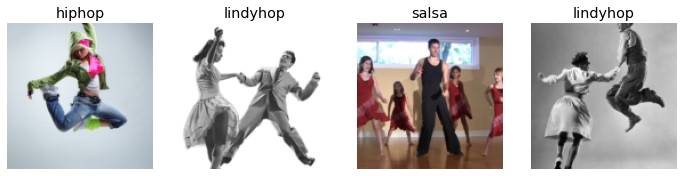

In [7]:
dls.valid.show_batch(max_n=4, nrows=1)

How it looks the dependent variable y

In [8]:
dsets = dancers.datasets(path)
dsets.train[0]

(PILImage mode=RGB size=300x300, TensorMultiCategory([0., 0., 1.]))

The dependent variable is represented in this way: TensorMultiCategory([1., 0., 0.]

We had a single integer representing each category, based on its location in our vocab. This is known as one-hot encoding.

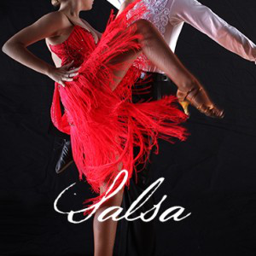

In [9]:
dsets.train[0][0].to_thumb(256,256)

In [10]:
dls.train.vocab

['hiphop', 'lindyhop', 'salsa']

## Data Augmentation

The "RandomResizedCrop" function select part of the image randomly, and crop to just that part. In this way our model can learn to focus on, and recognize different features in our images. It reflects how images work in the real world: different photos of the same thing may be framed in slightly different ways.

So actually training the neural network with examples of images where the objects are in slightly different places and slightly different sizes helps it to understand the basic concept of what an object is, and how it can be represented in an image.

Look at the example:

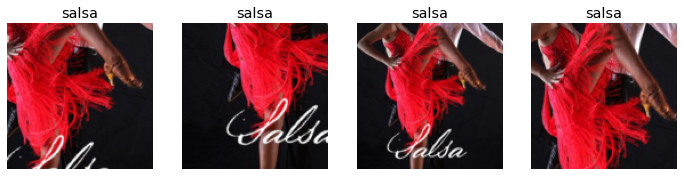

In [11]:
dancers = dancers.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = dancers.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

The "aug_transforms" function apply the common data augmentation techniques for images like: rotation, flipping, perspective warping, brightness changes and contrast changes.

Look at the example:

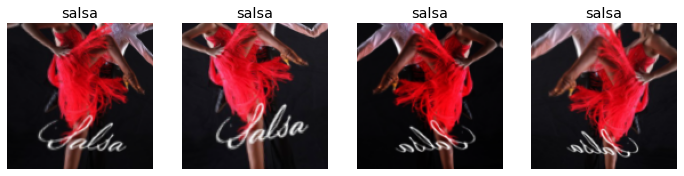

In [12]:
dancers = dancers.new(item_tfms=Resize(128), batch_tfms=aug_transforms())
dls = dancers.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

I apply these two functions to extend the dataset.

In [13]:
dancers = dancers.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = dancers.dataloaders(path)

## Training the model

Now we'll create our Learner. Learner object contains four main things: the model, a DataLoaders object, an Optimizer, and the loss function to use. 

Transfer Learning
We can take advantage of previously trained models to identify images. To do that we remove the last layer, adding a new one with corresponding number of outputs for our model. We freeze the values of all layers except the last one, which is the only one that needs training. We train for some epochs, later we train all layers but with different learning rate, to preserve the knowledge that the layers at the bottom already have. We define these parameters with "base_lr" and "freeze_epochs" params. This concept is call "Discriminative Learning Rates".

In this case we are gonna use resnet18 at the beggining, this model will help us to identify other parameters, like the right value for threshold to decide which categories are in an image. Later we can use a deeper model like resnet50 to improve our results.

We already have our DataLoaders. We are gonna use the optimizer by default which is Adam.

We need a Binary Cross Entropy as a loss function, however we don't actually need to tell fastai to use this loss function since it will be automatically chosen for us. fastai knows that the DataLoaders has multiple category labels, so it will use nn.BCEWithLogitsLoss by default. 

In [14]:
learn = cnn_learner(dls, resnet18, metrics=partial(accuracy_multi, thresh=0.45))
learn.fine_tune(4, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,1.088547,1.286843,0.447059,00:07
1,0.985003,0.834563,0.576471,00:07
2,0.847754,0.602573,0.729412,00:07
3,0.747801,0.426194,0.807843,00:06


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.430207,0.417154,0.819608,00:07
1,0.363678,0.413202,0.831373,00:06
2,0.320552,0.409796,0.843137,00:07
3,0.283208,0.388015,0.850980,00:06


Let's check which are the images with the top loss 

,target,predicted,probabilities,loss
0,salsa,hiphop,"tensor([0.9953, 0.0033, 0.0965])",2.5705184936523438
1,lindyhop,hiphop;salsa,"tensor([0.5258, 0.0124, 0.8789])",2.4171066284179688
2,salsa,hiphop,"tensor([0.9788, 0.0818, 0.1017])",2.07501220703125
3,salsa,hiphop,"tensor([0.9936, 0.0131, 0.4316])",1.9664949178695679
4,salsa,lindyhop,"tensor([0.0024, 0.9721, 0.1476])",1.8318042755126953


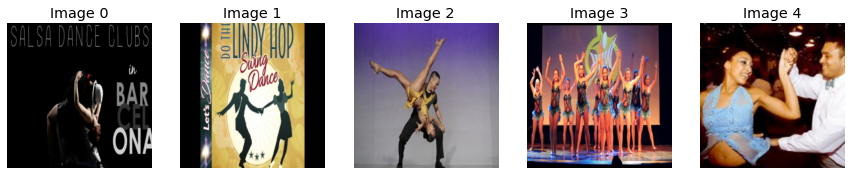

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(5, nrows=1)

Considering that some images are cartoons, flyers or objets like shoes or letters, people's postures and the size of our dataset the model is doing a good job.

## Improving our model

80% plus accuracy is not bad!, let's check how we can improve our model.

We are gonna find which is the best value for the threshold we use to decide if a category is included in an image. We get the predictions once and test for different values of threshold which give us the best results.

In [16]:
preds,targs = learn.get_preds()

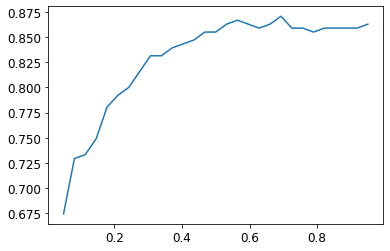

In [17]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

In [18]:
learn = cnn_learner(dls, resnet18, metrics=partial(accuracy_multi, thresh=0.8))
learn.fine_tune(4, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,1.001702,1.369761,0.509804,00:06
1,0.904032,0.741850,0.756863,00:07
2,0.792789,0.461778,0.815686,00:06
3,0.697214,0.375873,0.862745,00:06


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.393882,0.372309,0.878431,00:06
1,0.350690,0.396188,0.839216,00:06
2,0.306463,0.385446,0.878431,00:06
3,0.278096,0.353613,0.882353,00:06


We improved our model tunning the threshold!

## Deeper models

Another resource we have to improve our results is the use of a deeper model, in this case we will try with resnet50, the number in the name refers to number of layers. 

In general, a bigger model has the ability to better capture the real underlying relationships in your data, and also to capture and memorize the specific details of your individual images.

However, using a deeper model is going to require more GPU RAM and they take quite a bit longer to train.

There is a tradeoff in the choice of the model between computing resources, time available to develop the model and the desired results.
The choice of the model is a tradeoff between computing resources, time available to develop the model and the desired results.

In [19]:
learn = cnn_learner(dls, resnet101, metrics=partial(accuracy_multi, thresh=0.8))
learn.fine_tune(4, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.919622,1.504999,0.560784,00:10
1,0.751044,0.772950,0.776471,00:08
2,0.645007,0.435399,0.878431,00:09
3,0.558844,0.321114,0.894118,00:09


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.242986,0.511518,0.847059,00:10
1,0.233773,0.450747,0.858824,00:10
2,0.197005,0.384703,0.890196,00:10
3,0.167578,0.284425,0.921569,00:10


fastai can show us a graph of the training and validation loss:

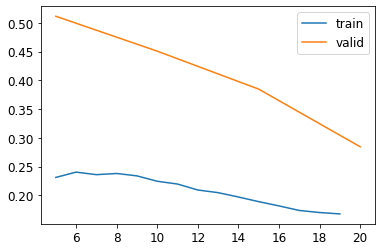

In [25]:
learn.recorder.plot_loss()

The training loss keeps getting better and better, however the validation loss improvement slows, and sometimes even gets worse, at this point the model starts to over fit. But this does not mean that it is getting less accurate. Actually accuracy continues improving. In the end what matters is your accuracy, or more generally your chosen metrics, not the loss. The loss is just the function we've given the computer to help us to optimize.

## Number of epochs

Often you will find that you are limited by time, rather than generalization and accuracy, when choosing how many epochs to train for. So your first approach to training should be to simply pick a number of epochs that will train in the amount of time that you are happy to wait for. Then look at the training and validation loss plots, as shown above, and in particular your metrics, and if you see that they are still getting better even in your final epochs, then you know that you have not trained for too long.

In [28]:
learn.fine_tune(2, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.024876,0.300301,0.909804,00:10
1,0.021425,0.254514,0.917647,00:10
2,0.021121,0.228382,0.913726,00:10
3,0.017906,0.234998,0.929412,00:10


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.027441,0.390624,0.905882,00:11
1,0.039567,0.335059,0.905882,00:11


Once you are happy with your results save the model.

In [20]:
learn.export()

let's check how it works with an image that was not in the training or validation dataset

In [32]:
btn_upload = widgets.FileUpload()
out_pl = widgets.Output()
lbl_pred = widgets.Label()
btn_run = widgets.Button(description='Classify')

def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(512,512))
    pred,pred_idx,probs = learn.predict(img)
    lbl_pred.value = f'Prediction: {pred}'

btn_run.on_click(on_click_classify)

In [33]:
#hide_output
VBox([widgets.Label('Select your dancer!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [ ]:
You can see the app that uses this model here: https://dancereco.herokuapp.com/
And the deployment process here: https://github.com/vhpvmx/dancereco